In [1]:
!pip install datasets
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DistilBertConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset



# Distillation using Masked Language Modelling

In [4]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    AutoModelForSequenceClassification,
)
import torch.optim as opt
from datasets import load_dataset
from tqdm import tqdm
import torch.nn.functional as F


# Finetune for MRPC


In [5]:
MODEL_PATH = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

In [8]:
mrpc = load_dataset("glue", "mrpc")

model_path="/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext"
tokenizer = AutoTokenizer.from_pretrained(model_path,local_files_only=True)

def preprocess(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=256
    )


encoded_mrpc = mrpc.map(preprocess, batched=True)
encoded_mrpc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [9]:
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(encoded_mrpc["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
test_loader = DataLoader(encoded_mrpc["test"], batch_size=BATCH_SIZE, collate_fn=data_collator)


**Load the distilled student model and add a classification head to it.**

In [10]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2).to(DEVICE)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_mrpc["train"],
    eval_dataset=encoded_mrpc["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-11-d70886cbf8e9>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.545000,0.494662
2,0.389200,0.412942
3,0.286100,0.436455


TrainOutput(global_step=690, training_loss=0.4209908665090367, metrics={'train_runtime': 271.6515, 'train_samples_per_second': 40.508, 'train_steps_per_second': 2.54, 'total_flos': 728835627405312.0, 'train_loss': 0.4209908665090367, 'epoch': 3.0})

In [12]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc"
model.save_pretrained(save_path)

In [18]:
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc/tokenizer.json')

# Finetune teacher on MRPC

In [13]:

# Load teacher model with classification head
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(DEVICE)

teacher_training_args = TrainingArguments(
    output_dir="./results-teacher",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs-teacher",
    logging_steps=100,
    report_to="none"
)

teacher_trainer = Trainer(
    model=teacher_model,
    args=teacher_training_args,
    train_dataset=encoded_mrpc["train"],
    eval_dataset=encoded_mrpc["test"],
    tokenizer=tokenizer,  # Use student tokenizer since it was already applied to data
    data_collator=data_collator,
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-899295c877b6>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  teacher_trainer = Trainer(


In [14]:
# === Train the teacher ===
teacher_trainer.train()

# === Evaluate the teacher ===
teacher_trainer.evaluate()

Epoch,Training Loss,Validation Loss
1,0.508300,0.420504
2,0.336600,0.409682
3,0.206300,0.461464


{'eval_loss': 0.46146419644355774,
 'eval_runtime': 22.2346,
 'eval_samples_per_second': 77.582,
 'eval_steps_per_second': 4.857,
 'epoch': 3.0}

In [15]:
teacher_finetuned_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc"
teacher_model.save_pretrained(teacher_finetuned_path)
tokenizer.save_pretrained(teacher_finetuned_path)

('/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc/tokenizer.json')

# Comparison of both finetuned models

In [16]:
student_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-distilled-mrpc"
teacher_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/finetuned-bert-mrpc"


In [19]:
from transformers import AutoModelForSequenceClassification
student = AutoModelForSequenceClassification.from_pretrained(student_model_path).to(DEVICE)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_model_path).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(student_model_path)

In [20]:
encoded_mrpc = mrpc.map(preprocess, batched=True)
encoded_mrpc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_dataset = encoded_mrpc["test"]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [21]:
def custom_collate(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

test_loader = DataLoader(encoded_mrpc["test"], batch_size=BATCH_SIZE, collate_fn=custom_collate)


In [22]:
from tqdm import tqdm
# data_collator = DataCollatorWithPadding(tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=data_collator)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Evaluate
student_accuracy = evaluate(student, test_loader)
teacher_accuracy = evaluate(teacher, test_loader)

print(f"Student accuracy: {student_accuracy:.4f}\n")
print(f"Teacher accuracy: {teacher_accuracy:.4f}")


100%|██████████| 108/108 [00:22<00:00,  4.70it/s]

Student accuracy: 0.8122

Teacher accuracy: 0.8284


In [23]:
student_size = sum(p.numel() for p in student.parameters()) / 1e6
teacher_size = sum(p.numel() for p in teacher.parameters()) / 1e6

print(f"Student model size: {student_size:.2f}M parameters")
print(f"Teacher model size: {teacher_size:.2f}M parameters")

Student model size: 66.96M parameters
Teacher model size: 109.48M parameters


In [24]:
import os
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, dataloader, model_path=None):
    model.eval()
    preds = []
    labels = []
    start_time = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            batch_labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds.append(logits.argmax(dim=-1).cpu())
            labels.append(batch_labels.cpu())

    end_time = time.time()
    total_time = end_time - start_time

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    conf_matrix = confusion_matrix(labels, preds)

    param_count = sum(p.numel() for p in model.parameters())

    # if model_path is not None:
    #     model_size = os.path.getsize(os.path.join(model_path, "pytorch_model.bin")) / (1024**2)  # in MB

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "inference_time_sec": total_time,
        "param_count": param_count,
    }


In [25]:
student_results = evaluate_model(student, test_loader, model_path=student_model_path)
teacher_results = evaluate_model(teacher, test_loader, model_path=teacher_model_path)


In [31]:
import pandas as pd

comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_results,
    },
    {
        "Model": "Teacher",
        **teacher_results,
    }
])


comparison_df = comparison_df[[
    "Model",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "inference_time_sec",
    "param_count"
]]


print(comparison_df.to_markdown(index=False))


| Model   |   accuracy |   precision |   recall |       f1 |   inference_time_sec |   param_count |
|:--------|-----------:|------------:|---------:|---------:|---------------------:|--------------:|
| Student |   0.812174 |    0.839242 | 0.887533 | 0.862712 |              11.1654 |      66955010 |
| Teacher |   0.828406 |    0.853699 | 0.895379 | 0.874043 |              21.8926 |     109483778 |


In [34]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/plots/comparison_results.csv"
comparison_df.to_csv(save_path, index=False)
print(f"Saved CSV to {save_path}")

Saved CSV to /content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/plots/comparison_results.csv


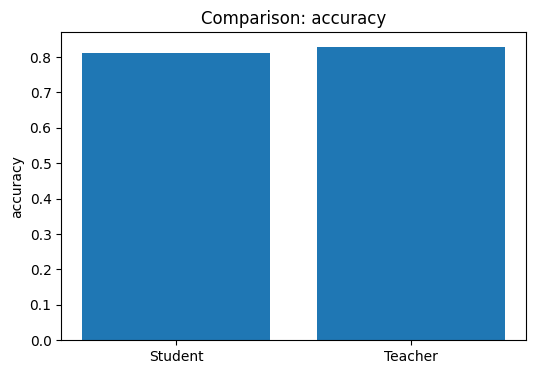

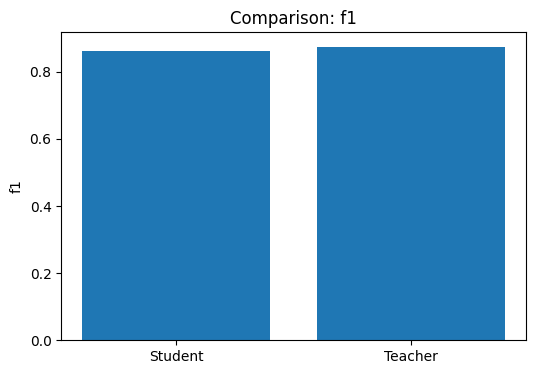

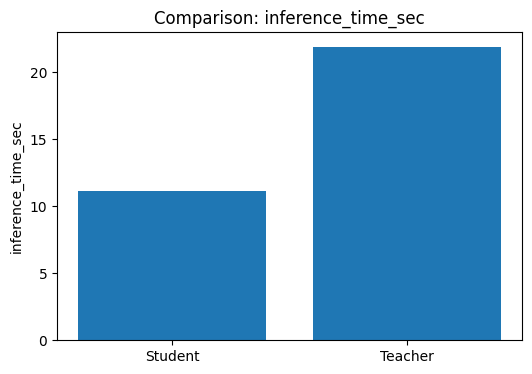

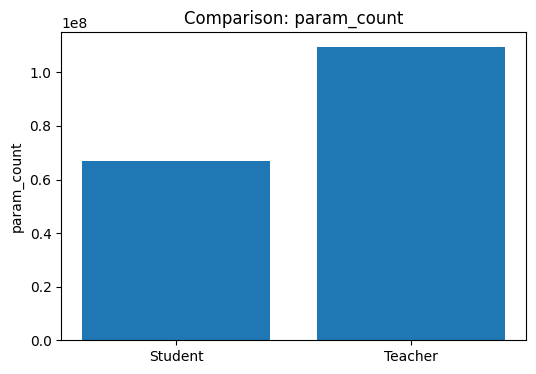

In [35]:
import matplotlib.pyplot as plt
import os


plots_dir = "/content/drive/MyDrive/CS4782FinalProject/artifacts/mrpc/plots"
os.makedirs(plots_dir, exist_ok=True)


metrics = ["accuracy", "f1", "inference_time_sec", "param_count"]

for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.bar(comparison_df["Model"], comparison_df[metric])
    plt.title(f"Comparison: {metric}")
    plt.ylabel(metric)
    plt.show()

    save_path = os.path.join(plots_dir, f"{metric}_comparison.png")
    plt.savefig(save_path)

    plt.close()

In [36]:
print(student_results)
print(teacher_results)

{'accuracy': 0.8121739130434783, 'precision': 0.8392415498763397, 'recall': 0.8875326939843069, 'f1': 0.8627118644067797, 'confusion_matrix': array([[ 383,  195],
       [ 129, 1018]]), 'inference_time_sec': 11.165449857711792, 'param_count': 66955010}
{'accuracy': 0.8284057971014492, 'precision': 0.8536990856192851, 'recall': 0.8953792502179599, 'f1': 0.8740425531914894, 'confusion_matrix': array([[ 402,  176],
       [ 120, 1027]]), 'inference_time_sec': 21.892611980438232, 'param_count': 109483778}
